Extracting embeddings and morphological features...


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Before SMOTE: [15505  2577]
After SMOTE : [15505 15505]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 01 -Accuracy: 0.7333 |  Loss: 0.5385 |  F1: 0.7650
Epoch 02 -Accuracy: 0.7460 |  Loss: 0.5083 |  F1: 0.7820
Epoch 03 -Accuracy: 0.7543 |  Loss: 0.4869 |  F1: 0.7736
Epoch 04 -Accuracy: 0.8064 |  Loss: 0.4304 |  F1: 0.8097
Epoch 05 -Accuracy: 0.8180 |  Loss: 0.4064 |  F1: 0.8282
Epoch 06 -Accuracy: 0.8149 |  Loss: 0.4057 |  F1: 0.8253
Epoch 07 -Accuracy: 0.8297 |  Loss: 0.3839 |  F1: 0.8398
Epoch 08 -Accuracy: 0.8233 |  Loss: 0.3868 |  F1: 0.8365
Epoch 09 -Accuracy: 0.8351 |  Loss: 0.3737 |  F1: 0.8358
Epoch 10 -Accuracy: 0.8599 |  Loss: 0.3376 |  F1: 0.8629

✅ Best Epoch: 10
✅ Best Accuracy: 0.8599
✅ Best Loss    : 0.3376
✅ Best F1-Score: 0.8629

📊 Classification Report:
              precision    recall  f1-score   support

  Non-Damage       0.88      0.84      0.86      3101
      Damage       0.84      0.88      0.86      3101

    accuracy                           0.86      6202
   macro avg       0.86      0.86      0.86      6202
weighted avg       0.86      0.86      0.8

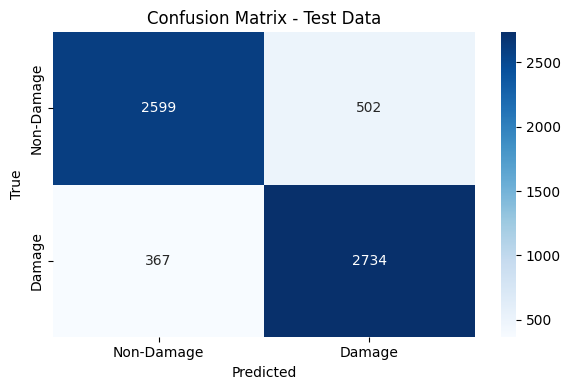

In [29]:
# ====================== Imports ======================
import pandas as pd
import numpy as np
import spacy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback

# ====================== Load spaCy model ======================
nlp = spacy.load("en_core_web_sm")

# ====================== Load Full Dataset ======================
df = pd.read_csv("/kaggle/input/mergefile/Merged_Disasters(2).csv")

# ====================== Preprocess Labels ======================
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
df['Processed_data'] = df['Processed_data'].fillna("")

# ====================== ELAMO Feature Extraction ======================
def get_spacy_embeddings(texts, fallback_dim=96):
    vectors = []
    for doc in nlp.pipe(texts, disable=["parser", "ner", "tagger"]):
        vec = doc.vector
        if vec is not None and vec.shape[0] > 0:
            vectors.append(vec)
        else:
            vectors.append(np.zeros(fallback_dim))
    return np.vstack(vectors)

def extract_morphological_features(texts):
    pos_tags = []
    lemmas = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        pos_tags.append([token.pos_ for token in doc])
        lemmas.append([token.lemma_ for token in doc])
    return pos_tags, lemmas

def combine_elamo_features(X_embed, pos_tags, lemmas):
    pos_diversity = np.array([[len(set(tags))] for tags in pos_tags])
    lemma_diversity = np.array([[len(set(l))] for l in lemmas])
    return np.hstack((X_embed, pos_diversity, lemma_diversity))

# ====================== Extract ELAMO Features on Full Data ======================
print("Extracting embeddings and morphological features...")
X_embed = get_spacy_embeddings(df['Processed_data'])
pos_tags, lemmas = extract_morphological_features(df['Processed_data'])
X_full = combine_elamo_features(X_embed, pos_tags, lemmas)
y_full = df['Binary_class'].values

# ====================== Apply SMOTE on Full Data ======================
print("Before SMOTE:", np.bincount(y_full))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_full, y_full)
print("After SMOTE :", np.bincount(y_balanced))

# ====================== Split into 80/20 Train/Test ======================
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# ====================== Define CNN Model ======================
input_dim = X_train.shape[1]
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ====================== Custom Callback to Track Test Metrics ======================
class TestMetricsCallback(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_epoch = -1
        self.best_results = {}

    def on_epoch_end(self, epoch, logs=None):
        y_pred_proba = self.model.predict(self.X_test, verbose=0).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        acc = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        loss = tf.keras.losses.binary_crossentropy(self.y_test, y_pred_proba).numpy().mean()

        print(f"Epoch {epoch+1:02d} -Accuracy: {acc:.4f} |  Loss: {loss:.4f} |  F1: {f1:.4f}")

        # Save best epoch by F1
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_epoch = epoch + 1
            self.best_results = {
                'accuracy': acc,
                'loss': loss,
                'f1': f1,
                'y_pred': y_pred,
                'y_proba': y_pred_proba
            }

# ====================== Train Model on Training Data Only ======================
metrics_callback = TestMetricsCallback(X_test, y_test)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    verbose=0,  # silent training
    callbacks=[metrics_callback]
)

# ====================== Final Best Results ======================
print(f"\n✅ Best Epoch: {metrics_callback.best_epoch}")
print(f"✅ Best Accuracy: {metrics_callback.best_results['accuracy']:.4f}")
print(f"✅ Best Loss    : {metrics_callback.best_results['loss']:.4f}")
print(f"✅ Best F1-Score: {metrics_callback.best_results['f1']:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, metrics_callback.best_results['y_pred'], target_names=['Non-Damage', 'Damage']))

# ====================== Confusion Matrix ======================
cm = confusion_matrix(y_test, metrics_callback.best_results['y_pred'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Data")
plt.tight_layout()
plt.show()
